premiere objectif : aller rapidement à un modèle baseline, donc on peut suivre une stratégie "premier modèle simple, puis amélioration".

- Modèle simple d’abord	On sélectionne quelques variables avec peu ou pas de NaN, et on lance une régression logistique rapide	Pour obtenir un premier score de base (baseline)

- Puis traitement des NaN	On traite les colonnes avec des NaN (par imputation ou suppression) au cas par cas	Pour améliorer ensuite la qualité du modèle

- Puis itérations	Sélection de variables, équilibre des classes, tuning...	Pour monter en performance

In [1]:
import sklearn
print(sklearn.__version__)

1.3.0


--------Étape 1 : Chargement des données depuis X_clean.csv-----------

In [2]:
# features = [
#     'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
#     'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
#     'HAS_JOB', 'OWN_CAR_AGE', 'FLOORSMAX_MEDI',
#     'NAME_INCOME_TYPE_Unemployed', 'CODE_GENDER_M',
#     'NAME_EDUCATION_TYPE_Lower secondary'
# ]

In [3]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [4]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [5]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [6]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [7]:
# Import des librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import warnings
!pip install imblearn

# # Chargement des données nettoyées
# # data = pd.read_csv("p4_X_clean.csv")
# data = pd.read_csv("p4_X_clean_encoded.csv")

# # Vérification rapide
# print(data.shape)
# data.head()
warnings.filterwarnings("ignore")

# Chargement des données préparées depuis analyse.ipynb
data = pd.read_csv("data_cleaned_ready.csv")

# Séparation X et y
X = data.drop(columns='TARGET')
y = data['TARGET']

# Split train / validation stratifié
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Données chargées et prêtes pour modélisation")
print(f"Train : {X_train.shape}, Validation : {X_val.shape}")

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Données chargées et prêtes pour modélisation
Train : (79087, 40), Validation : (19772, 40)


In [8]:
data = pd.read_csv("p4_X_clean_encoded.csv")

# Affichage du nombre de lignes et de colonnes
nb_lignes, nb_colonnes = data.shape
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")

Nombre de lignes : 307511
Nombre de colonnes : 147


In [9]:
data = pd.read_csv("data_cleaned_ready.csv")

# 🔹 Affichage du nombre de lignes et de colonnes
nb_lignes, nb_colonnes = data.shape
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")

Nombre de lignes : 98859
Nombre de colonnes : 41


Matrice de confusion :
[[20318     0]
 [ 1600     0]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20318
           1       0.00      0.00      0.00      1600

    accuracy                           0.93     21918
   macro avg       0.46      0.50      0.48     21918
weighted avg       0.86      0.93      0.89     21918


AUC ROC : 0.5725


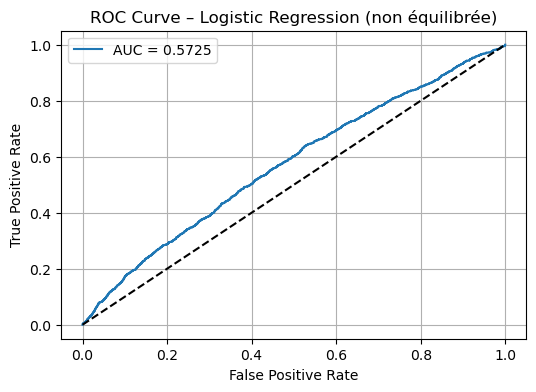

In [10]:
#  Chargement des données nettoyées et encodées
data = pd.read_csv("p4_X_clean_encoded.csv")

#  Sélection de variables simples (quantitatives et bien corrélées)
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']

# On garde uniquement les lignes sans NaN sur ces colonnes
data_model = data[['TARGET'] + features].dropna()

# Séparation X / y
X = data_model.drop(columns='TARGET')
y = data_model['TARGET']

# 🔹 Split train / validation (stratifié)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Régression logistique sans équilibrage
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

#  Prédictions
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# Évaluation
print("Matrice de confusion :")
print(confusion_matrix(y_val, y_pred))

print("\nRapport de classification :")
print(classification_report(y_val, y_pred))

auc = roc_auc_score(y_val, y_proba)
print(f"\nAUC ROC : {auc:.4f}")

#  Courbe ROC
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression (non équilibrée)')
plt.legend()
plt.grid(True)
plt.show()


Matrice de confusion (format lisible) :

               Prédit 0    Prédit 1
Réel 0     ➤     20318      0
Réel 1     ➤     1600       0

Vrais négatifs (TN) : 20318
Faux positifs  (FP) : 0
Faux négatifs  (FN) : 1600
Vrais positifs  (TP) : 0


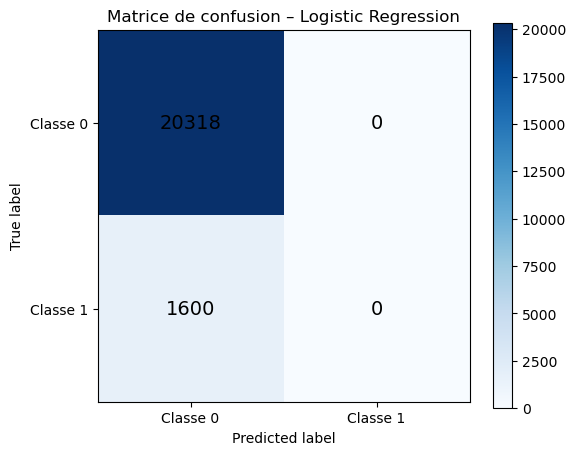


Rapport de classification :
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20318
           1       0.00      0.00      0.00      1600

    accuracy                           0.93     21918
   macro avg       0.46      0.50      0.48     21918
weighted avg       0.86      0.93      0.89     21918


AUC ROC : 0.5725


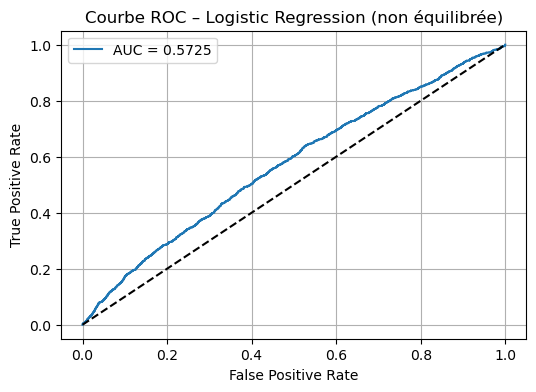

In [11]:
# regression logistique — sans équilibrage

# Chargement des données
data = pd.read_csv("p4_X_clean_encoded.csv")

# Sélection de variables simples (quantitatives et bien corrélées)
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']
data_model = data[['TARGET'] + features].dropna()

# Séparation X / y
X = data_model.drop(columns='TARGET')
y = data_model['TARGET']

# Split train / validation (stratifié)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Régression logistique
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

# Affichage lisible en console
print("\nMatrice de confusion (format lisible) :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

print(f"Vrais négatifs (TN) : {tn}")
print(f"Faux positifs  (FP) : {fp}")
print(f"Faux négatifs  (FN) : {fn}")
print(f"Vrais positifs  (TP) : {tp}")

# Affichage graphique propre
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=None)  # Désactive les annotations automatiques

# Supprimer les annotations par défaut (au cas où)
for text in disp.text_.ravel():
    text.set_visible(False)

# Ajout manuel des vraies valeurs au centre
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)

plt.title("Matrice de confusion – Logistic Regression")
plt.grid(False)
plt.show()

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_val, y_pred))

# Score AUC ROC
auc = roc_auc_score(y_val, y_proba)
print(f"\nAUC ROC : {auc:.4f}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – Logistic Regression (non équilibrée)")
plt.legend()
plt.grid(True)
plt.show()


Matrice de confusion (Dummy - sans équilibrage) :

               Prédit 0    Prédit 1
Réel 0     ➤     20318      0
Réel 1     ➤     1600       0



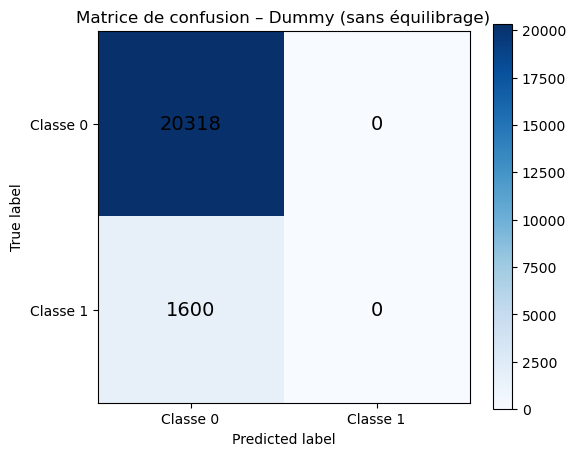


Rapport de classification :
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20318
           1       0.00      0.00      0.00      1600

    accuracy                           0.93     21918
   macro avg       0.46      0.50      0.48     21918
weighted avg       0.86      0.93      0.89     21918


AUC ROC : 0.5000


In [12]:
# Dummy Classifier — sans équilibrage

# Chargement des données
data = pd.read_csv("p4_X_clean_encoded.csv")
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']
data_model = data[['TARGET'] + features].dropna()

X = data_model.drop(columns='TARGET')
y = data_model['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Dummy Classifier (stratégie la plus fréquente)
model = DummyClassifier(strategy='most_frequent')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nMatrice de confusion (Dummy - sans équilibrage) :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
for text in disp.text_.ravel(): text.set_visible(False)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)
plt.title("Matrice de confusion – Dummy (sans équilibrage)")
plt.grid(False)
plt.show()

print("\nRapport de classification :")
print(classification_report(y_val, y_pred))

auc = roc_auc_score(y_val, y_proba)
print(f"\nAUC ROC : {auc:.4f}")


Matrice de confusion – Logistic Regression balanced :

               Prédit 0    Prédit 1
Réel 0     ➤     14141      6177
Réel 1     ➤     523        1077



<Figure size 640x480 with 0 Axes>

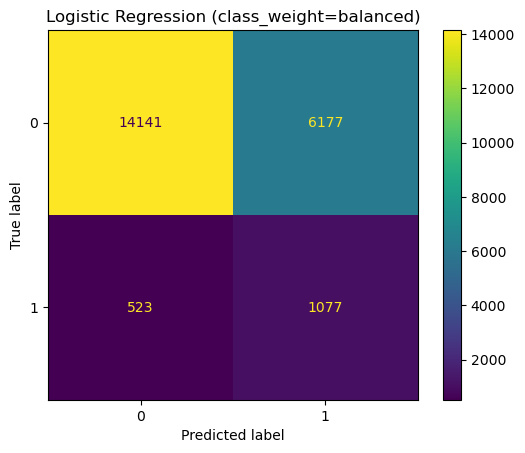

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     20318
           1       0.15      0.67      0.24      1600

    accuracy                           0.69     21918
   macro avg       0.56      0.68      0.53     21918
weighted avg       0.90      0.69      0.77     21918

AUC ROC : 0.7489

Matrice de confusion – Logistic Regression SMOTE :

               Prédit 0    Prédit 1
Réel 0     ➤     19863      455
Réel 1     ➤     1557       43



<Figure size 640x480 with 0 Axes>

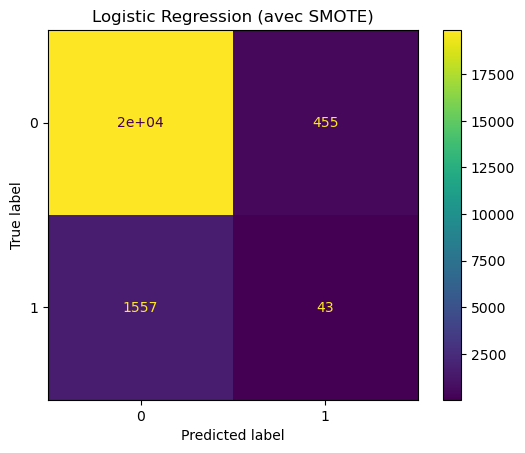

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     20318
           1       0.09      0.03      0.04      1600

    accuracy                           0.91     21918
   macro avg       0.51      0.50      0.50     21918
weighted avg       0.87      0.91      0.89     21918

AUC ROC : 0.5427


In [13]:
# 2. Logistic Regression — class_weight='balanced' & SMOTE

# Régression logistique avec class_weight='balanced'
model_bal = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
model_bal.fit(X_train, y_train)
y_pred_bal = model_bal.predict(X_val)
y_proba_bal = model_bal.predict_proba(X_val)[:, 1]

cm_bal = confusion_matrix(y_val, y_pred_bal)
tn, fp, fn, tp = cm_bal.ravel()

print("\nMatrice de confusion – Logistic Regression balanced :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

plt.figure()
ConfusionMatrixDisplay(cm_bal).plot()
plt.title("Logistic Regression (class_weight=balanced)")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

# Logistic Regression avec SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression(max_iter=1000, solver='liblinear')
model_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = model_smote.predict(X_val)
y_proba_sm = model_smote.predict_proba(X_val)[:, 1]

cm_sm = confusion_matrix(y_val, y_pred_sm)
tn, fp, fn, tp = cm_sm.ravel()

print("\nMatrice de confusion – Logistic Regression SMOTE :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

plt.figure()
ConfusionMatrixDisplay(cm_sm).plot()
plt.title("Logistic Regression (avec SMOTE)")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


Dummy Stratified (approximation balanced) :
[[18797  1521]
 [ 1481   119]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     20318
           1       0.07      0.07      0.07      1600

    accuracy                           0.86     21918
   macro avg       0.50      0.50      0.50     21918
weighted avg       0.86      0.86      0.86     21918

AUC ROC : 0.4998


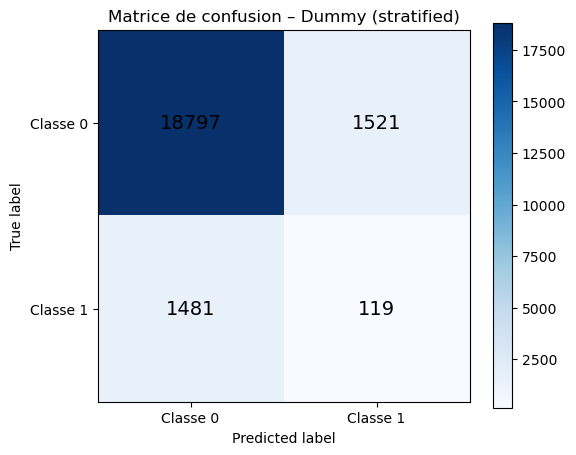


Dummy Classifier avec SMOTE :
[[10163 10155]
 [  813   787]]
              precision    recall  f1-score   support

           0       0.93      0.50      0.65     20318
           1       0.07      0.49      0.13      1600

    accuracy                           0.50     21918
   macro avg       0.50      0.50      0.39     21918
weighted avg       0.86      0.50      0.61     21918

AUC ROC : 0.4960


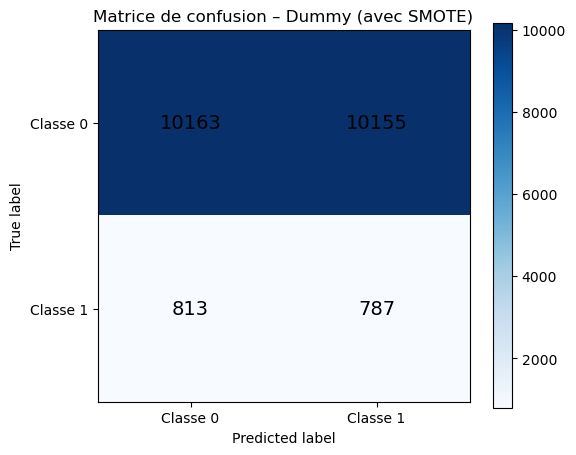

In [14]:
# 3. Dummy Classifier — avec class_weight='balanced' et SMOTE

# Dummy "balanced" approximé avec stratified
model_strat = DummyClassifier(strategy='stratified', random_state=42)
model_strat.fit(X_train, y_train)
y_pred_strat = model_strat.predict(X_val)
y_proba_strat = model_strat.predict_proba(X_val)[:, 1]

# Affichage résultats Dummy Stratified
print("\nDummy Stratified (approximation balanced) :")
cm_strat = confusion_matrix(y_val, y_pred_strat)
print(cm_strat)
print(classification_report(y_val, y_pred_strat))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_strat):.4f}")

# Affichage graphique
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_strat, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=None)
for text in disp.text_.ravel():
    text.set_visible(False)
for (i, j), val in np.ndenumerate(cm_strat):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)
plt.title("Matrice de confusion – Dummy (stratified)")
plt.grid(False)
plt.show()


# Dummy avec SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

model_dummy_sm = DummyClassifier(strategy='stratified', random_state=42)
model_dummy_sm.fit(X_train_sm, y_train_sm)
y_pred_dummy_sm = model_dummy_sm.predict(X_val)
y_proba_dummy_sm = model_dummy_sm.predict_proba(X_val)[:, 1]

# 🔸 Affichage résultats Dummy SMOTE
print("\nDummy Classifier avec SMOTE :")
cm_sm = confusion_matrix(y_val, y_pred_dummy_sm)
print(cm_sm)
print(classification_report(y_val, y_pred_dummy_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_dummy_sm):.4f}")

# Affichage graphique
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sm, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=None)
for text in disp.text_.ravel():
    text.set_visible(False)
for (i, j), val in np.ndenumerate(cm_sm):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)
plt.title("Matrice de confusion – Dummy (avec SMOTE)")
plt.grid(False)
plt.show()


Matrice de confusion – Logistic Regression balanced :

               Prédit 0    Prédit 1
Réel 0     ➤     12591      5690
Réel 1     ➤     481        1010



<Figure size 640x480 with 0 Axes>

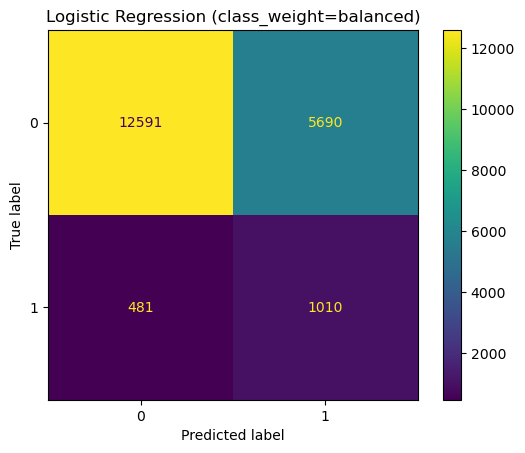


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     18281
           1       0.15      0.68      0.25      1491

    accuracy                           0.69     19772
   macro avg       0.56      0.68      0.52     19772
weighted avg       0.90      0.69      0.76     19772

AUC ROC : 0.7494

Matrice de confusion – Logistic Regression SMOTE :

               Prédit 0    Prédit 1
Réel 0     ➤     13045      5236
Réel 1     ➤     558        933



<Figure size 640x480 with 0 Axes>

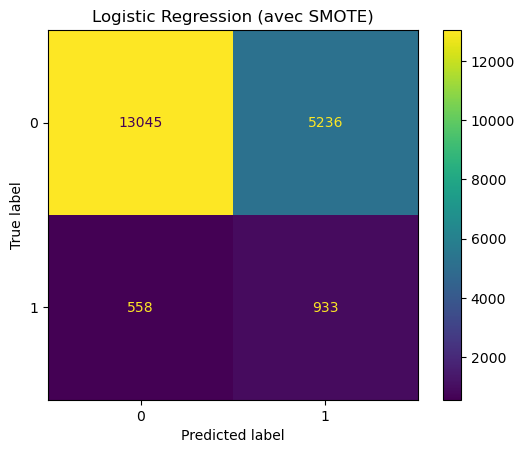


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     18281
           1       0.15      0.63      0.24      1491

    accuracy                           0.71     19772
   macro avg       0.56      0.67      0.53     19772
weighted avg       0.90      0.71      0.77     19772

AUC ROC : 0.7295


In [15]:
# TEST avec top 10 features regression logistique avec equilibrage

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

# Sélection des variables
features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary'
]

# Préparation des données
data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

# Split des données
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ----------------------------------------------------
# 1. Logistic Regression — class_weight='balanced'
model_bal = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
model_bal.fit(X_train, y_train)
y_pred_bal = model_bal.predict(X_val)
y_proba_bal = model_bal.predict_proba(X_val)[:, 1]

# Matrice de confusion
cm_bal = confusion_matrix(y_val, y_pred_bal)
tn, fp, fn, tp = cm_bal.ravel()

print("\nMatrice de confusion – Logistic Regression balanced :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

plt.figure()
ConfusionMatrixDisplay(cm_bal).plot()
plt.title("Logistic Regression (class_weight=balanced)")
plt.grid(False)
plt.show()

print("\nClassification Report :")
print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

# ----------------------------------------------------
# 2. Logistic Regression avec SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression(max_iter=1000, solver='liblinear')
model_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = model_smote.predict(X_val)
y_proba_sm = model_smote.predict_proba(X_val)[:, 1]

cm_sm = confusion_matrix(y_val, y_pred_sm)
tn, fp, fn, tp = cm_sm.ravel()

print("\nMatrice de confusion – Logistic Regression SMOTE :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

plt.figure()
ConfusionMatrixDisplay(cm_sm).plot()
plt.title("Logistic Regression (avec SMOTE)")
plt.grid(False)
plt.show()

print("\nClassification Report :")
print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


 Matrice de confusion – DummyClassifier (stratified) :

               Prédit 0    Prédit 1
Réel 0     ➤     16872      1409
Réel 1     ➤     1384       107



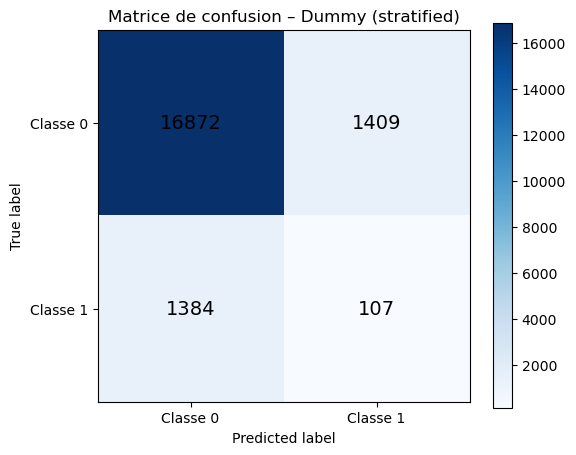


 Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18281
           1       0.07      0.07      0.07      1491

    accuracy                           0.86     19772
   macro avg       0.50      0.50      0.50     19772
weighted avg       0.86      0.86      0.86     19772

AUC ROC : 0.4973

 Matrice de confusion – DummyClassifier avec SMOTE :

               Prédit 0    Prédit 1
Réel 0     ➤     9122       9159
Réel 1     ➤     747        744



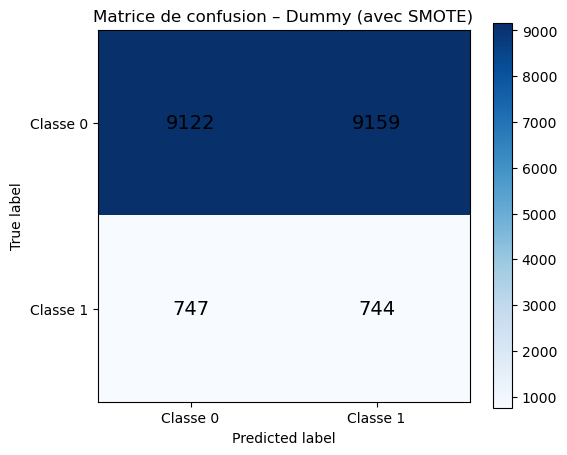


 Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.50      0.65     18281
           1       0.08      0.50      0.13      1491

    accuracy                           0.50     19772
   macro avg       0.50      0.50      0.39     19772
weighted avg       0.86      0.50      0.61     19772

AUC ROC : 0.4990


In [16]:
# TEST avec top 10 features dummy classifer avec equilibrage

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

# Sélection des 12 features
features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary'
]

# Préparation des données
data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

# Split des données
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ----------------------------------------------------
# 🔹 1. Dummy Classifier – stratégie "stratified" (approx. balanced)
model_strat = DummyClassifier(strategy='stratified', random_state=42)
model_strat.fit(X_train, y_train)
y_pred_strat = model_strat.predict(X_val)
y_proba_strat = model_strat.predict_proba(X_val)[:, 1]

cm_strat = confusion_matrix(y_val, y_pred_strat)
tn, fp, fn, tp = cm_strat.ravel()

print("\n Matrice de confusion – DummyClassifier (stratified) :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_strat, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=None)
for text in disp.text_.ravel():
    text.set_visible(False)
for (i, j), val in np.ndenumerate(cm_strat):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)
plt.title("Matrice de confusion – Dummy (stratified)")
plt.grid(False)
plt.show()

print("\n Classification Report :")
print(classification_report(y_val, y_pred_strat))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_strat):.4f}")

# ----------------------------------------------------
# 🔹 2. Dummy Classifier – avec SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

model_dummy_sm = DummyClassifier(strategy='stratified', random_state=42)
model_dummy_sm.fit(X_train_sm, y_train_sm)
y_pred_dummy_sm = model_dummy_sm.predict(X_val)
y_proba_dummy_sm = model_dummy_sm.predict_proba(X_val)[:, 1]

cm_dummy_sm = confusion_matrix(y_val, y_pred_dummy_sm)
tn, fp, fn, tp = cm_dummy_sm.ravel()

print("\n Matrice de confusion – DummyClassifier avec SMOTE :\n")
print(f"               Prédit 0    Prédit 1")
print(f"Réel 0     ➤     {tn:<10} {fp}")
print(f"Réel 1     ➤     {fn:<10} {tp}\n")

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dummy_sm, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=None)
for text in disp.text_.ravel():
    text.set_visible(False)
for (i, j), val in np.ndenumerate(cm_dummy_sm):
    ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=14)
plt.title("Matrice de confusion – Dummy (avec SMOTE)")
plt.grid(False)
plt.show()

print("\n Classification Report :")
print(classification_report(y_val, y_pred_dummy_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_dummy_sm):.4f}")


Matrice – Random Forest (balanced)


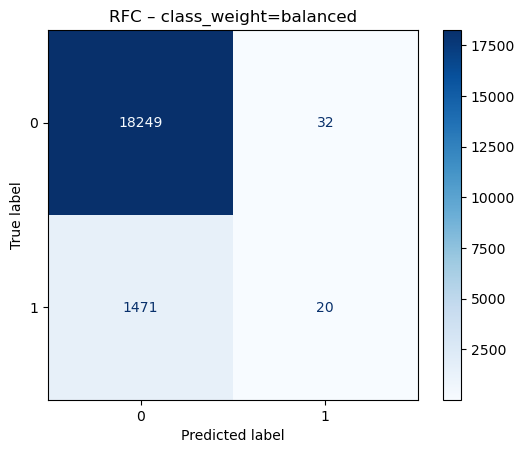

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18281
           1       0.38      0.01      0.03      1491

    accuracy                           0.92     19772
   macro avg       0.66      0.51      0.49     19772
weighted avg       0.88      0.92      0.89     19772

AUC ROC : 0.7031

Matrice – Random Forest (SMOTE)


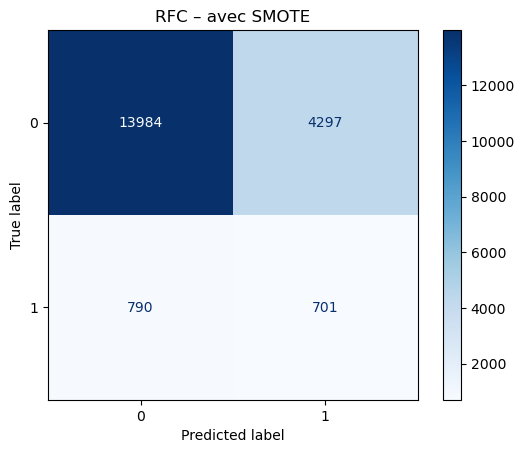

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     18281
           1       0.14      0.47      0.22      1491

    accuracy                           0.74     19772
   macro avg       0.54      0.62      0.53     19772
weighted avg       0.89      0.74      0.80     19772

AUC ROC : 0.6919


In [17]:
# RFC avec equilibrage top 5 features

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']
data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ---------------- RFC balanced ----------------
model_bal = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_bal.fit(X_train, y_train)
y_pred_bal = model_bal.predict(X_val)
y_proba_bal = model_bal.predict_proba(X_val)[:, 1]

cm_bal = confusion_matrix(y_val, y_pred_bal)
print("\nMatrice – Random Forest (balanced)")
ConfusionMatrixDisplay(cm_bal).plot(cmap=plt.cm.Blues)
plt.title("RFC – class_weight=balanced")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

# ---------------- RFC avec SMOTE ----------------
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = model_smote.predict(X_val)
y_proba_sm = model_smote.predict_proba(X_val)[:, 1]

cm_sm = confusion_matrix(y_val, y_pred_sm)
print("\nMatrice – Random Forest (SMOTE)")
ConfusionMatrixDisplay(cm_sm).plot(cmap=plt.cm.Blues)
plt.title("RFC – avec SMOTE")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


Matrice – Random Forest (balanced)


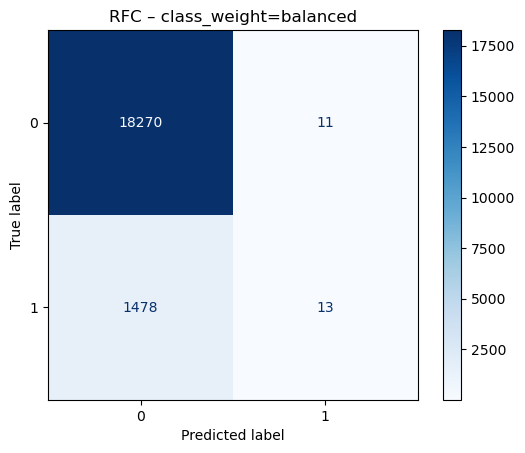

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18281
           1       0.54      0.01      0.02      1491

    accuracy                           0.92     19772
   macro avg       0.73      0.50      0.49     19772
weighted avg       0.90      0.92      0.89     19772

AUC ROC : 0.7158

Matrice – Random Forest (SMOTE)


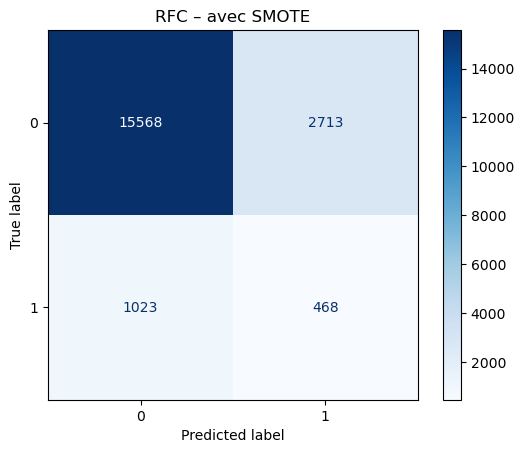

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     18281
           1       0.15      0.31      0.20      1491

    accuracy                           0.81     19772
   macro avg       0.54      0.58      0.55     19772
weighted avg       0.88      0.81      0.84     19772

AUC ROC : 0.6830


In [18]:
# RFC avec equilibrage top 10 features

# Bloc 2 – RFC avec SMOTE & balanced – Features étendues
features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary'
]

data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ---------------- RFC balanced ----------------
model_bal = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_bal.fit(X_train, y_train)
y_pred_bal = model_bal.predict(X_val)
y_proba_bal = model_bal.predict_proba(X_val)[:, 1]

cm_bal = confusion_matrix(y_val, y_pred_bal)
print("\nMatrice – Random Forest (balanced)")
ConfusionMatrixDisplay(cm_bal).plot(cmap=plt.cm.Blues)
plt.title("RFC – class_weight=balanced")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

# ---------------- RFC avec SMOTE ----------------
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = model_smote.predict(X_val)
y_proba_sm = model_smote.predict_proba(X_val)[:, 1]

cm_sm = confusion_matrix(y_val, y_pred_sm)
print("\nMatrice – Random Forest (SMOTE)")
ConfusionMatrixDisplay(cm_sm).plot(cmap=plt.cm.Blues)
plt.title("RFC – avec SMOTE")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


🟦 XGBoost avec scale_pos_weight – features_minus


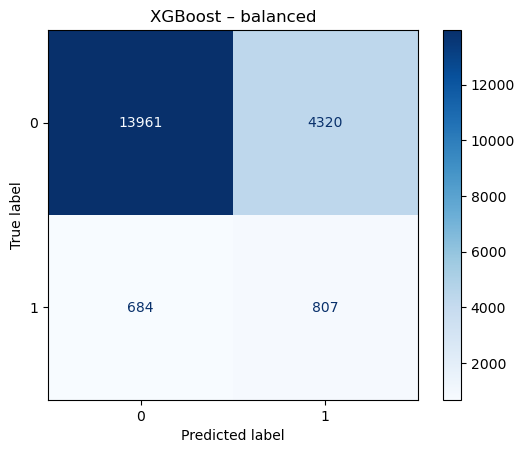

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     18281
           1       0.16      0.54      0.24      1491

    accuracy                           0.75     19772
   macro avg       0.56      0.65      0.55     19772
weighted avg       0.89      0.75      0.80     19772

AUC ROC: 0.7160580498838259

🟩 XGBoost avec SMOTE – features_minus


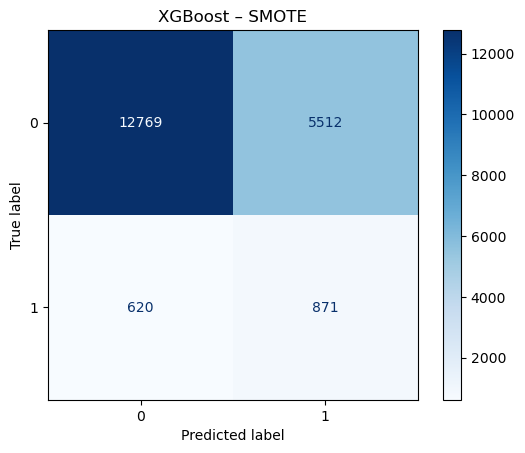

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     18281
           1       0.14      0.58      0.22      1491

    accuracy                           0.69     19772
   macro avg       0.55      0.64      0.51     19772
weighted avg       0.89      0.69      0.76     19772

AUC ROC: 0.6979976975431349


In [19]:
# 1. XGBoost – Équilibré et SMOTE – features_minus

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")
features_minus = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']
data_model = data[['TARGET'] + features_minus].dropna()
X, y = data_model[features_minus], data_model['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. XGBoost avec scale_pos_weight
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model_xgb_bal = XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_bal.fit(X_train, y_train)
y_pred = model_xgb_bal.predict(X_val)
y_proba = model_xgb_bal.predict_proba(X_val)[:, 1]

print("\n🟦 XGBoost avec scale_pos_weight – features_minus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot(cmap='Blues')
plt.grid(False)
plt.title("XGBoost – balanced")
plt.show()
print(classification_report(y_val, y_pred))
print("AUC ROC:", roc_auc_score(y_val, y_proba))

# 2. XGBoost avec SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
model_xgb_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_xgb_sm.predict(X_val)
y_proba_sm = model_xgb_sm.predict_proba(X_val)[:, 1]

print("\n🟩 XGBoost avec SMOTE – features_minus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_sm)).plot(cmap='Blues')
plt.grid(False)
plt.title("XGBoost – SMOTE")
plt.show()
print(classification_report(y_val, y_pred_sm))
print("AUC ROC:", roc_auc_score(y_val, y_proba_sm))


🟦 XGBoost avec scale_pos_weight – features_plus


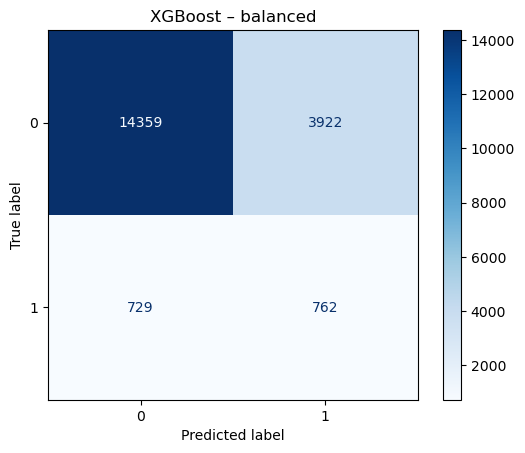

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     18281
           1       0.16      0.51      0.25      1491

    accuracy                           0.76     19772
   macro avg       0.56      0.65      0.55     19772
weighted avg       0.89      0.76      0.81     19772

AUC ROC: 0.7106096455105008

🟩 XGBoost avec SMOTE – features_plus


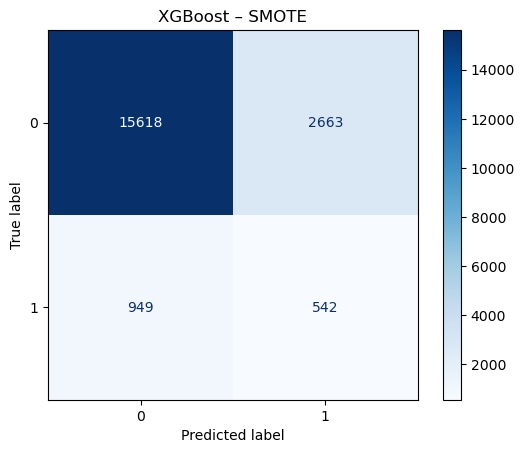

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     18281
           1       0.17      0.36      0.23      1491

    accuracy                           0.82     19772
   macro avg       0.56      0.61      0.56     19772
weighted avg       0.88      0.82      0.85     19772

AUC ROC: 0.6923170223133012


In [20]:
# 2. XGBoost – Équilibré et SMOTE – features_plus

features_plus = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
    'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'HAS_JOB',
    'OWN_CAR_AGE', 'CODE_GENDER_M', 'NAME_EDUCATION_TYPE_Lower secondary'
]

data_model = data[['TARGET'] + features_plus].dropna()
X, y = data_model[features_plus], data_model['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. Balanced
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model_xgb_bal = XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_bal.fit(X_train, y_train)
y_pred = model_xgb_bal.predict(X_val)
y_proba = model_xgb_bal.predict_proba(X_val)[:, 1]

print("\n🟦 XGBoost avec scale_pos_weight – features_plus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot(cmap='Blues')
plt.grid(False)
plt.title("XGBoost – balanced")
plt.show()
print(classification_report(y_val, y_pred))
print("AUC ROC:", roc_auc_score(y_val, y_proba))

# 2. SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
model_xgb_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_xgb_sm.predict(X_val)
y_proba_sm = model_xgb_sm.predict_proba(X_val)[:, 1]

print("\n🟩 XGBoost avec SMOTE – features_plus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_sm)).plot(cmap='Blues')
plt.grid(False)
plt.title("XGBoost – SMOTE")
plt.show()
print(classification_report(y_val, y_pred_sm))
print("AUC ROC:", roc_auc_score(y_val, y_proba_sm))

[LightGBM] [Info] Number of positive: 5966, number of negative: 73121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 79087, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(



🟦 LightGBM – balanced – features_minus


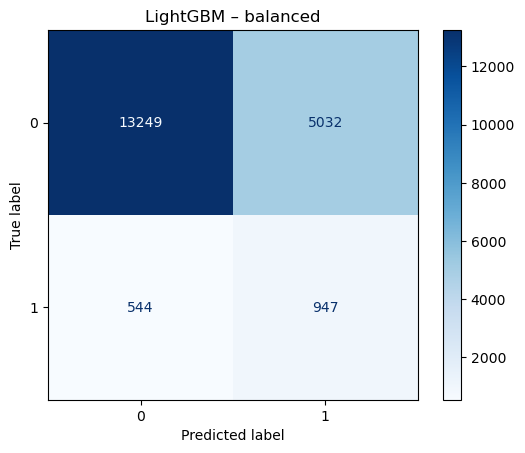

              precision    recall  f1-score   support

           0       0.96      0.72      0.83     18281
           1       0.16      0.64      0.25      1491

    accuracy                           0.72     19772
   macro avg       0.56      0.68      0.54     19772
weighted avg       0.90      0.72      0.78     19772

AUC ROC: 0.7473520076753943
[LightGBM] [Info] Number of positive: 73121, number of negative: 73121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 146242, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🟩 LightGBM – SMOTE – features_minus


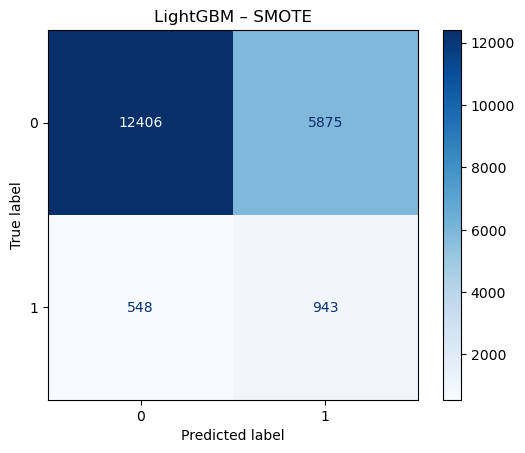

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     18281
           1       0.14      0.63      0.23      1491

    accuracy                           0.68     19772
   macro avg       0.55      0.66      0.51     19772
weighted avg       0.90      0.68      0.75     19772

AUC ROC: 0.7161414780827994


In [21]:
# 3. LightGBM – Équilibré et SMOTE – features_minus

# Reprise des mêmes features_minus
data_model = data[['TARGET'] + features_minus].dropna()
X, y = data_model[features_minus], data_model['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. LGBM balanced
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model_lgbm_bal = LGBMClassifier(class_weight='balanced', random_state=42)
model_lgbm_bal.fit(X_train, y_train)
y_pred = model_lgbm_bal.predict(X_val)
y_proba = model_lgbm_bal.predict_proba(X_val)[:, 1]

print("\n🟦 LightGBM – balanced – features_minus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot(cmap='Blues')
plt.grid(False)
plt.title("LightGBM – balanced")
plt.show()
print(classification_report(y_val, y_pred))
print("AUC ROC:", roc_auc_score(y_val, y_proba))

# 2. LGBM avec SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
model_lgbm_sm = LGBMClassifier(random_state=42)
model_lgbm_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_lgbm_sm.predict(X_val)
y_proba_sm = model_lgbm_sm.predict_proba(X_val)[:, 1]

print("\n🟩 LightGBM – SMOTE – features_minus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_sm)).plot(cmap='Blues')
plt.grid(False)
plt.title("LightGBM – SMOTE")
plt.show()
print(classification_report(y_val, y_pred_sm))
print("AUC ROC:", roc_auc_score(y_val, y_proba_sm))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5966, number of negative: 73121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 79087, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

🟦 LightGBM – balanced – features_plus


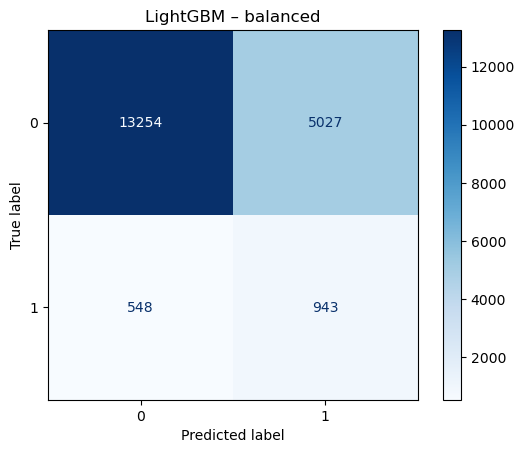

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     18281
           1       0.16      0.63      0.25      1491

    accuracy                           0.72     19772
   macro avg       0.56      0.68      0.54     19772
weighted avg       0.90      0.72      0.78     19772

AUC ROC: 0.7436844504842449
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 73121, number of negative: 73121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 146242, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🟩 LightGBM – SMOTE – features_plus


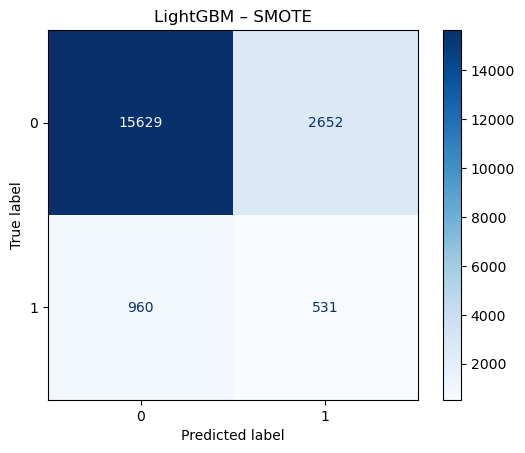

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     18281
           1       0.17      0.36      0.23      1491

    accuracy                           0.82     19772
   macro avg       0.55      0.61      0.56     19772
weighted avg       0.88      0.82      0.85     19772

AUC ROC: 0.7028782104952161


In [22]:
 # 4. LightGBM – Équilibré et SMOTE – features_plus

data_model = data[['TARGET'] + features_plus].dropna()
X, y = data_model[features_plus], data_model['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. balanced
model_lgbm_bal = LGBMClassifier(class_weight='balanced', random_state=42)
model_lgbm_bal.fit(X_train, y_train)
y_pred = model_lgbm_bal.predict(X_val)
y_proba = model_lgbm_bal.predict_proba(X_val)[:, 1]

print("\n🟦 LightGBM – balanced – features_plus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot(cmap='Blues')
plt.grid(False)
plt.title("LightGBM – balanced")
plt.show()
print(classification_report(y_val, y_pred))
print("AUC ROC:", roc_auc_score(y_val, y_proba))

# 2. SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
model_lgbm_sm = LGBMClassifier(random_state=42)
model_lgbm_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_lgbm_sm.predict(X_val)
y_proba_sm = model_lgbm_sm.predict_proba(X_val)[:, 1]

print("\n🟩 LightGBM – SMOTE – features_plus")
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_sm)).plot(cmap='Blues')
plt.grid(False)
plt.title("LightGBM – SMOTE")
plt.show()
print(classification_report(y_val, y_pred_sm))
print("AUC ROC:", roc_auc_score(y_val, y_proba_sm))

je constate que l'ajout de features supplémentaire diminue l'AUC, plutot que de reduire le nombre de features en gardant les plus pertinantes je devrais peut etre m'attarder un peu plus sur les NaN que j'avais supprimé par defauld et en remplacer un maximum dans la phase de nettoyage. Mais pour le moment je vais tester d'autre modèle avec et sans équilibrage et m'interesser sur ce que apportent les équilibrages.

--------Utiliser SMOTE pour équilibrer les classes----------

avec un grand nombre de features

=== Coefficients Logistic Regression ===
                               Feature  Coefficient
0                         EXT_SOURCE_1    -0.543565
2                         EXT_SOURCE_3    -0.543227
1                         EXT_SOURCE_2    -0.370822
3                           DAYS_BIRTH    -0.210365
7                          OWN_CAR_AGE    -0.042829
4               DAYS_LAST_PHONE_CHANGE     0.026731
8                        CODE_GENDER_M     0.024955
9  NAME_EDUCATION_TYPE_Lower secondary     0.006488
5                    DAYS_REGISTRATION     0.002202
6                              HAS_JOB     0.000000

=== Importances CatBoost ===
                               Feature  Importance
2                         EXT_SOURCE_3   33.054723
0                         EXT_SOURCE_1   29.734511
1                         EXT_SOURCE_2   22.373867
3                           DAYS_BIRTH    6.035909
7                          OWN_CAR_AGE    4.168817
4               DAYS_LAST_PHONE_CHANGE    1.760149


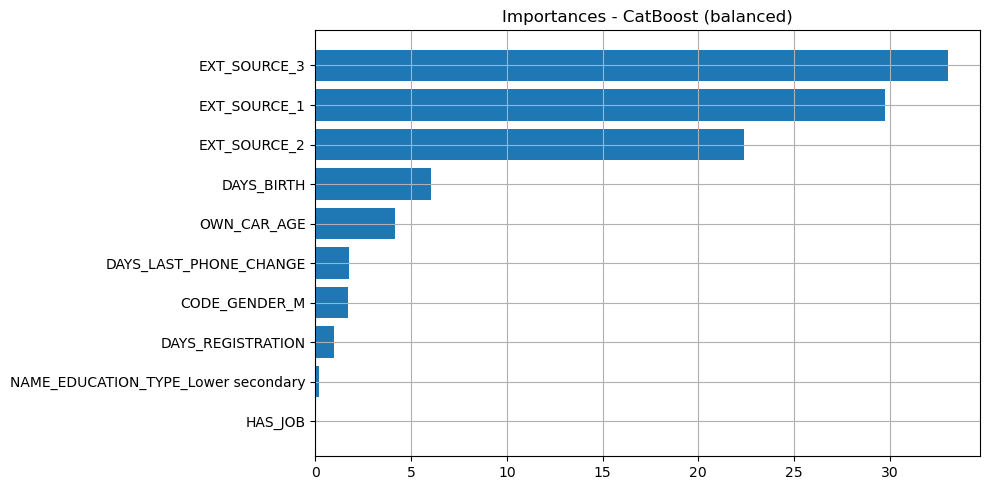

In [23]:
# ==== Données ====
# Supposons que ton jeu de données s'appelle 'data' et contient 'TARGET'
features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary'
]

X = data[features].copy()
y = data['TARGET'].copy()

# Convertir HAS_JOB au cas où
X['HAS_JOB'] = X['HAS_JOB'].fillna(0).astype(int)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalisation pour LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ========================
# Logistic Regression (balanced)
# ========================
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("=== Coefficients Logistic Regression ===")
print(coef_df)

# ========================
# CatBoostClassifier (balanced)
# ========================
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=4,
    class_weights=[1, 12],  # Balanced: poids inversement proportionnels
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)

# Importances
importances = cat_model.get_feature_importance()
catboost_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Importances CatBoost ===")
print(catboost_df)

# Plot si tu veux
plt.figure(figsize=(10, 5))
plt.barh(catboost_df['Feature'], catboost_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Importances - CatBoost (balanced)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Les EXT_SOURCE_* sont ultra importantes, mais elles meritent un traitement des NaN par imputation intelligente (ex. : moyenne, médiane, KNN, ou un modèle simple de prédiction de ces valeurs).

- DAYS_EMPLOYED_CLEANED, DAYS_BIRTH, AMT_CREDIT et d'autres sont interessantes, je continue de les exploiter.

- Les variables catégorielles encodées (one-hot)
Elles apparaissent mais avec une importance plus faible, ce qui est normal.

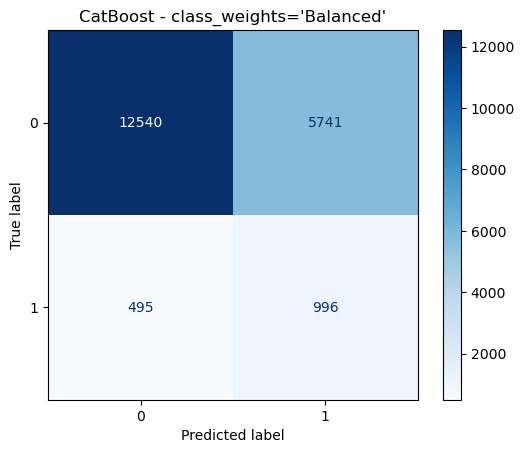

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     18281
           1       0.15      0.67      0.24      1491

    accuracy                           0.68     19772
   macro avg       0.55      0.68      0.52     19772
weighted avg       0.90      0.68      0.76     19772

AUC ROC : 0.7466


In [24]:
# CatBoost avec class_weights='Balanced'

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'AMT_INCOME_TOTAL'
]

data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Modèle CatBoost avec class_weights
model_cb_bal = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    class_weights=[1, len(y_train) / y_train.sum()],
    verbose=0,
    random_state=42
)

model_cb_bal.fit(X_train, y_train)

# Prédictions
y_pred_bal = model_cb_bal.predict(X_val)
y_proba_bal = model_cb_bal.predict_proba(X_val)[:, 1]

# Affichage résultats
cm = confusion_matrix(y_val, y_pred_bal)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CatBoost - class_weights='Balanced'")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

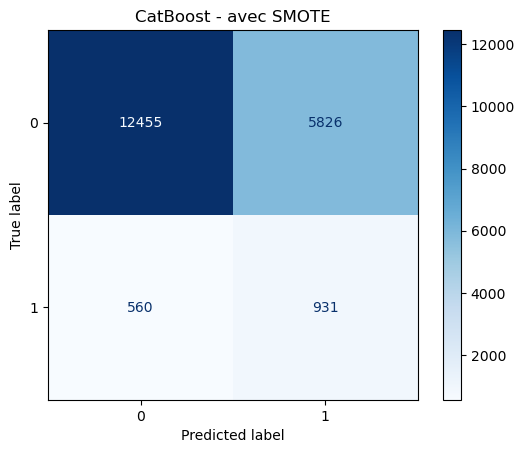

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     18281
           1       0.14      0.62      0.23      1491

    accuracy                           0.68     19772
   macro avg       0.55      0.65      0.51     19772
weighted avg       0.90      0.68      0.75     19772

AUC ROC : 0.7146


In [25]:
# CatBoost avec SMOTE

# SMOTE sur jeu d'entraînement
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Modèle CatBoost sans class_weights car SMOTE équilibre déjà
model_cb_smote = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

model_cb_smote.fit(X_train_sm, y_train_sm)

# Prédictions
y_pred_sm = model_cb_smote.predict(X_val)
y_proba_sm = model_cb_smote.predict_proba(X_val)[:, 1]

# Affichage résultats
cm = confusion_matrix(y_val, y_pred_sm)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CatBoost - avec SMOTE")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


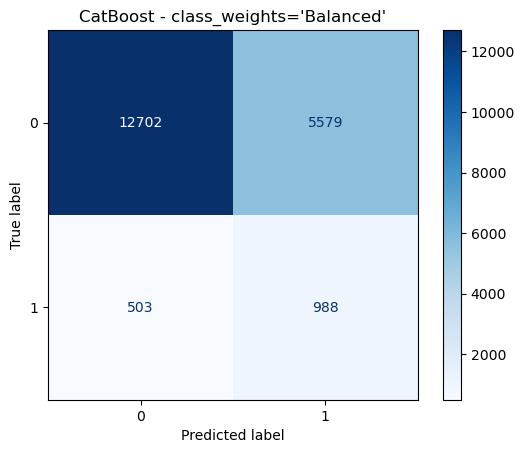

              precision    recall  f1-score   support

           0       0.96      0.69      0.81     18281
           1       0.15      0.66      0.25      1491

    accuracy                           0.69     19772
   macro avg       0.56      0.68      0.53     19772
weighted avg       0.90      0.69      0.76     19772

AUC ROC : 0.7429


In [26]:
# CatBoost avec class_weights='Balanced'

# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary'
]

data_model = data[['TARGET'] + features].dropna()
X = data_model[features]
y = data_model['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Modèle CatBoost avec class_weights
model_cb_bal = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    class_weights=[1, len(y_train) / y_train.sum()],
    verbose=0,
    random_state=42
)

model_cb_bal.fit(X_train, y_train)

# Prédictions
y_pred_bal = model_cb_bal.predict(X_val)
y_proba_bal = model_cb_bal.predict_proba(X_val)[:, 1]

# Affichage résultats
cm = confusion_matrix(y_val, y_pred_bal)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CatBoost - class_weights='Balanced'")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_bal))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_bal):.4f}")

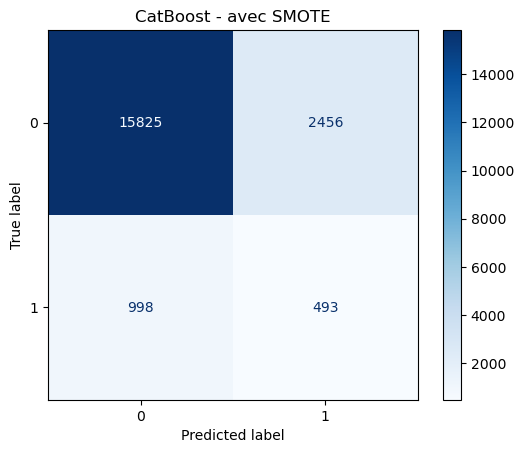

              precision    recall  f1-score   support

           0       0.94      0.87      0.90     18281
           1       0.17      0.33      0.22      1491

    accuracy                           0.83     19772
   macro avg       0.55      0.60      0.56     19772
weighted avg       0.88      0.83      0.85     19772

AUC ROC : 0.6988


In [27]:
# CatBoost avec SMOTE

# SMOTE sur jeu d'entraînement
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Modèle CatBoost sans class_weights car SMOTE équilibre déjà
model_cb_smote = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

model_cb_smote.fit(X_train_sm, y_train_sm)

# Prédictions
y_pred_sm = model_cb_smote.predict(X_val)
y_proba_sm = model_cb_smote.predict_proba(X_val)[:, 1]

# Affichage résultats
cm = confusion_matrix(y_val, y_pred_sm)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CatBoost - avec SMOTE")
plt.grid(False)
plt.show()

print(classification_report(y_val, y_pred_sm))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba_sm):.4f}")


In [28]:
# Définir les données et les features

# Sélection des 5 meilleures variables
top5_features = ['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED_CLEANED']

# X et y
X = data[top5_features]
y = data['TARGET']

# Train / Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
# Définir le modèle de base + grille d'hyperparamètres

# Modèle de base LightGBM avec équilibrage des classes
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    random_state=42
)

# Grille de recherche aléatoire
param_dist = {
    'n_estimators': [30, 50, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'num_leaves': [15, 20, 31],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [30]:
# Recherche aléatoire d’hyperparamètres

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Entraînement
random_search.fit(X_train, y_train)

# Résultat
best_lgb = random_search.best_estimator_
print("Meilleurs hyperparamètres :", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib

[LightGBM] [Info] Number of positive: 3977, number of negative: 48748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 52725, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075429 -> initscore=-2.506136
[LightGBM] [Info] Start training from score -2.506136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     18281
           1       0.15      0.67      0.25      1491

    accuracy                           0.69     19772
   macro avg       0.56      0.68      0.53     19772
weighted avg       0.90      0.69      0.77     19772

AUC ROC : 0.7488


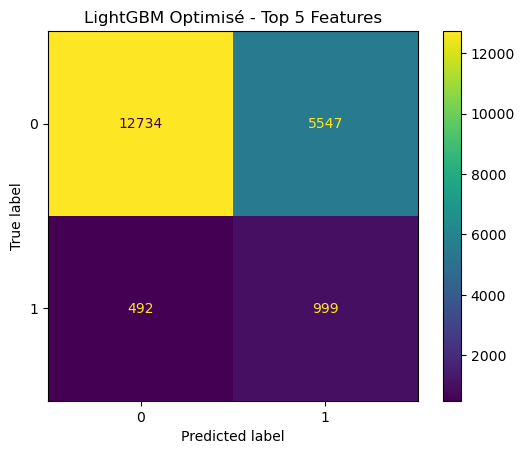

In [31]:
# Évaluation sur les données de validation

# Prédictions
y_pred = best_lgb.predict(X_val)
y_proba = best_lgb.predict_proba(X_val)[:, 1]

# Résultats
print("\nClassification Report :")
print(classification_report(y_val, y_pred))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba):.4f}")

# Affichage matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("LightGBM Optimisé - Top 5 Features")
plt.grid(False)
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

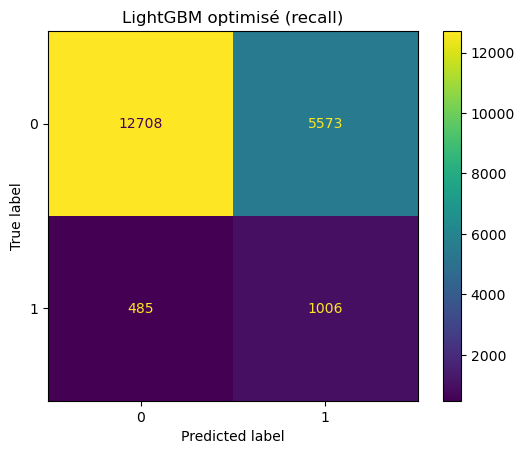

In [32]:
# Base model
lgb_base = LGBMClassifier(
    objective='binary',
    class_weight='balanced',  # pour l'équilibrage
    random_state=42
)

# Grille d'hyperparamètres à tester
param_dist = {
    'n_estimators': [20, 40, 60, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'num_leaves': [15, 31, 63],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV avec RECALL comme scoring
search_recall = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement sur X_train et y_train (s'assurer-qu'ils sont bien définis avec les top 5 variables)
search_recall.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
print("✅ Meilleurs hyperparamètres (optimisé pour le recall) :")
print(search_recall.best_params_)

# Évaluation sur le set de validation
best_recall_model = search_recall.best_estimator_
y_pred = best_recall_model.predict(X_val)
y_proba = best_recall_model.predict_proba(X_val)[:, 1]

# Rapport
print("\nClassification Report :")
print(classification_report(y_val, y_pred))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba):.4f}")

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("LightGBM optimisé (recall)")
plt.grid(False)
plt.show()

In [33]:
# Chargement des données
data = pd.read_csv("data_cleaned_ready.csv")

# Vérif rapide
print("Colonnes disponibles :", data.columns.tolist())

# 1. Création de l’âge en années
data['AGE_YEARS'] = (-data['DAYS_BIRTH'] / 365).astype(int)

# 2. Est-ce un jeune client ? (< 30 ans)
data['IS_YOUNG'] = (data['AGE_YEARS'] < 30).astype(int)

# 3. Ancienneté d'emploi longue (> 8 ans ≈ 3000 jours)
if 'DAYS_EMPLOYED' in data.columns:
    data['LONG_EMPLOYED'] = (data['DAYS_EMPLOYED'] < -3000).astype(int)
else:
    print("⚠️ Colonne 'DAYS_EMPLOYED' manquante")

# 4. Téléphone changé récemment (moins d’un an)
data['PHONE_CHANGED_RECENTLY'] = (data['DAYS_LAST_PHONE_CHANGE'] > -365).astype(int)

# 5. Ratio crédit / revenu
data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

# 6. Ratio annuité / revenu
data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']

# 7. Crédit par enfant
# data['CREDIT_PER_CHILD'] = data['AMT_CREDIT'] / (data['CNT_CHILDREN'] + 1)

# 8. Revenu par membre de la famille
# data['INCOME_PER_FAM_MEMBER'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)

# 9. A-t-il un emploi ? (365243 = sans emploi)
if 'DAYS_EMPLOYED' in data.columns:
    data['HAS_JOB'] = data['DAYS_EMPLOYED'].apply(lambda x: 1 if x != 365243 else 0)
else:
    print("⚠️ Colonne 'DAYS_EMPLOYED' manquante")

# Liste des nouvelles variables créées
new_vars = [
    'AGE_YEARS', 'IS_YOUNG', 'LONG_EMPLOYED', 'PHONE_CHANGED_RECENTLY',
    'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_PER_CHILD',
    'INCOME_PER_FAM_MEMBER', 'HAS_JOB'
]

# Retirer les variables qui n’existent pas
new_vars = [var for var in new_vars if var in data.columns]

# Vérifier la corrélation avec TARGET
df_corr = data[new_vars + ['TARGET']]
correlations = df_corr.corr()['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)

# Affichage
print("\n🔍 Corrélations avec la cible (TARGET) :")
print(correlations)

Colonnes disponibles : ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED_CLEANED', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'HAS_JOB', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_21', 'CODE_GENDER_M', 'CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apart

In [34]:
print(data['HAS_JOB'].value_counts(dropna=False))

HAS_JOB
1    98859
Name: count, dtype: int64


une variable avec 0.02 de corrélation peut aider un arbre de décision à créer un split très informatif en combinaison avec d’autres variables.

In [35]:
features_enriched = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'AMT_INCOME_TOTAL',
    'AGE_YEARS', 'IS_YOUNG', 'PHONE_CHANGED_RECENTLY',
    'ANNUITY_INCOME_RATIO', 'CREDIT_INCOME_RATIO'
]

In [36]:
X = data[features_enriched]
y = data['TARGET']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [37]:
model_lgb_balanced = LGBMClassifier(
    class_weight='balanced',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model_lgb_balanced.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 5966, number of negative: 73121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 79087, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=4,
               random_state=42)


📊 Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     18281
           1       0.16      0.67      0.25      1491

    accuracy                           0.70     19772
   macro avg       0.56      0.69      0.53     19772
weighted avg       0.90      0.70      0.77     19772

AUC ROC : 0.7546


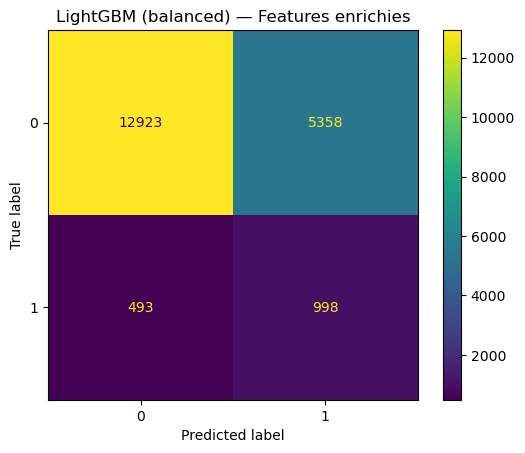

In [38]:
y_pred = model_lgb_balanced.predict(X_val)
y_proba = model_lgb_balanced.predict_proba(X_val)[:, 1]

print("\n📊 Classification Report :")
print(classification_report(y_val, y_pred))
print(f"AUC ROC : {roc_auc_score(y_val, y_proba):.4f}")

ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("LightGBM (balanced) — Features enrichies")
plt.grid(False)
plt.show()


In [39]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__session__', 'rlcompleter', 'readline', 'os', '_i', '_ii', '_iii', '_i1', 'sklearn', '_i2', '_i3', '_exit_code', '_i4', '_i5', '_i6', '_i7', 'pd', 'np', 'plt', 'mtick', 'train_test_split', 'LogisticRegression', 'confusion_matrix', 'ConfusionMatrixDisplay', 'classification_report', 'roc_auc_score', 'roc_curve', 'StandardScaler', 'SMOTE', 'RandomForestClassifier', 'DummyClassifier', 'LGBMClassifier', 'lgb', 'XGBClassifier', 'CatBoostClassifier', 'shap', 'RandomizedSearchCV', 'sns', 'warnings', 'data', 'X', 'y', 'X_train', 'X_val', 'y_train', 'y_val', '_i8', 'nb_lignes', 'nb_colonnes', '_i9', '_i10', 'features', 'data_model', 'model', 'y_pred', 'y_proba', 'auc', 'fpr', 'tpr', '_i11', 'cm', 'tn', 'fp', 'fn', 'tp', 'fig', 'ax', 'disp', 'text', 'i', 'j', 'val', '_i12', '_i13', 'model_bal', 'y_pre

In [40]:
# Liste des features enrichies
features_enriched = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
    'HAS_JOB', 'OWN_CAR_AGE', 'CODE_GENDER_M',
    'NAME_EDUCATION_TYPE_Lower secondary',
    'AGE_YEARS', 'IS_YOUNG', 'PHONE_CHANGED_RECENTLY',
    'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO'
]

# Séparation
X = data[features_enriched]
y = data['TARGET']

X_train_enriched, X_val_enriched, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

best_model = LGBMClassifier(
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=100,
    max_depth=4,
    num_leaves=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
best_model.fit(X_train_enriched, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5966, number of negative: 73121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 79087, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, max_depth=4, num_leaves=15, random_state=42,
               subsample=0.8)

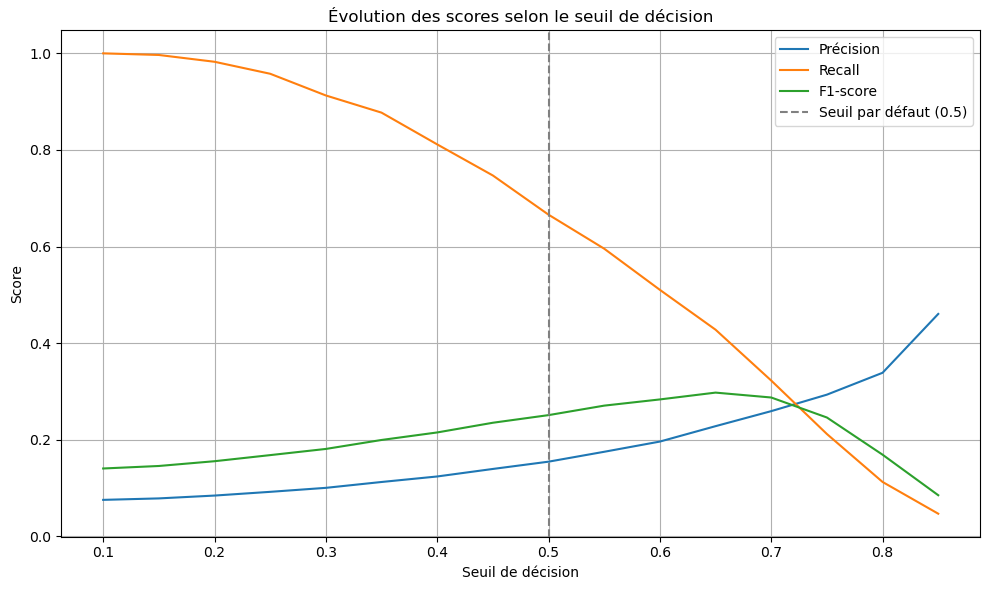

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Prédictions de probabilités avec le modèle LightGBM optimisé
y_proba = best_model.predict_proba(X_val_enriched)[:, 1]

# 2. Seuils à tester
thresholds = np.arange(0.1, 0.9, 0.05)

# 3. Stockage des métriques
precision_scores = []
recall_scores = []
f1_scores = []

# 4. Calcul des métriques pour chaque seuil
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision_scores.append(precision_score(y_val, y_pred_thresh))
    recall_scores.append(recall_score(y_val, y_pred_thresh))
    f1_scores.append(f1_score(y_val, y_pred_thresh))

# 5. Affichage graphique
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Précision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut (0.5)')
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.title("Évolution des scores selon le seuil de décision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ligne orange (Recall) :

Le recall est très haut pour les faibles seuils (0.1 à 0.4), ce qui est attendu.

Il diminue fortement quand le seuil augmente (on devient plus strict pour prédire un positif).

Si on veux prioriser les clients risqués, il est judicieux de favoriser un seuil bas pour garder un bon recall.

Ligne bleue (Précision) :

À l’inverse, la précision est très basse aux faibles seuils (beaucoup de faux positifs).

Elle augmente avec le seuil (on devient plus sûr pour prédire un positif).

Si on choisi un seuil trop bas (ex : 0.1), on risque de surcharger les équipes avec de fausses alertes.

Ligne verte (F1-score) :

Le F1-score atteint son pic autour de 0.65.

Ce point est souvent un compromis idéal entre rappel et précision.

--------------Conclusion (recommandation de seuil)-------------

Si recall est prioritaire, on peux envisager un seuil vers 0.4 :

Recall élevé (~0.75-0.80)

Précision encore raisonnable

F1-score correct

Si on veux un compromis équilibré, alors le meilleur F1-score est obtenu vers 0.65 :

Bon équilibre entre ne pas rater de clients risqués et ne pas générer trop de faux positifs.

📌 Résultats avec seuil personnalisé = 0.4

              precision    recall  f1-score   support

           0      0.972     0.533     0.688     18281
           1      0.124     0.812     0.215      1491

    accuracy                          0.554     19772
   macro avg      0.548     0.672     0.452     19772
weighted avg      0.908     0.554     0.652     19772

AUC ROC (probas) : 0.7545


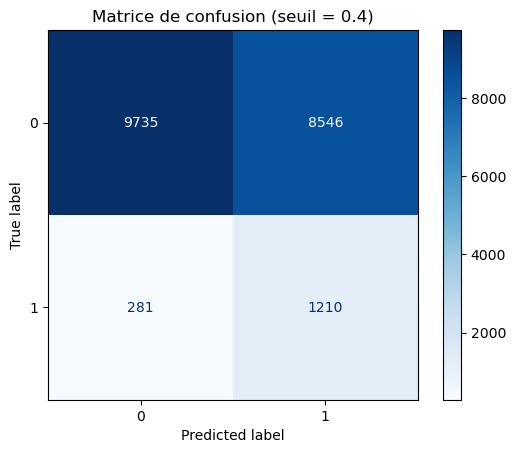

In [42]:
# 1. Définir le seuil choisi (par exemple 0.4 si tu veux booster le recall)
seuil_optimal = 0.4  # à ajuster selon ton graphique

# 2. Prédictions finales avec seuil personnalisé
y_pred_final = (y_proba >= seuil_optimal).astype(int)

# 3. Rapport de classification
print(f"📌 Résultats avec seuil personnalisé = {seuil_optimal}\n")
print(classification_report(y_val, y_pred_final, digits=3))

# Calcul de l'AUC ROC avec les probabilités (pas les classes)
auc = roc_auc_score(y_val, y_proba)
print(f"AUC ROC (probas) : {auc:.4f}")

# 4. Matrice de confusion
cm = confusion_matrix(y_val, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Matrice de confusion (seuil = {seuil_optimal})")
plt.grid(False)
plt.show()


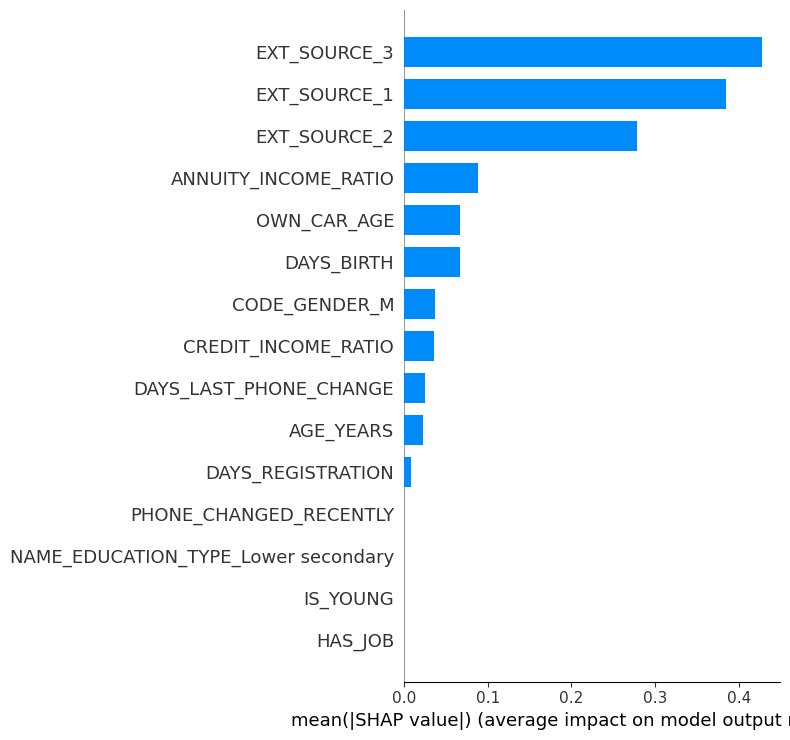

In [43]:
# Explicabilité globale (SHAP summary plots)

# Visualiser quelles variables influencent le plus les prédictions

# Voir si leur effet est positif ou négatif

# Identifier les patterns globaux

# 1. Initialiser l'explainer avec LightGBM
explainer = shap.TreeExplainer(best_model)

# 2. Calculer les valeurs SHAP sur l'échantillon de validation
shap_values = explainer(X_val_enriched)

# 3. Summary plot (global)
shap.summary_plot(shap_values, X_val_enriched, plot_type="bar")

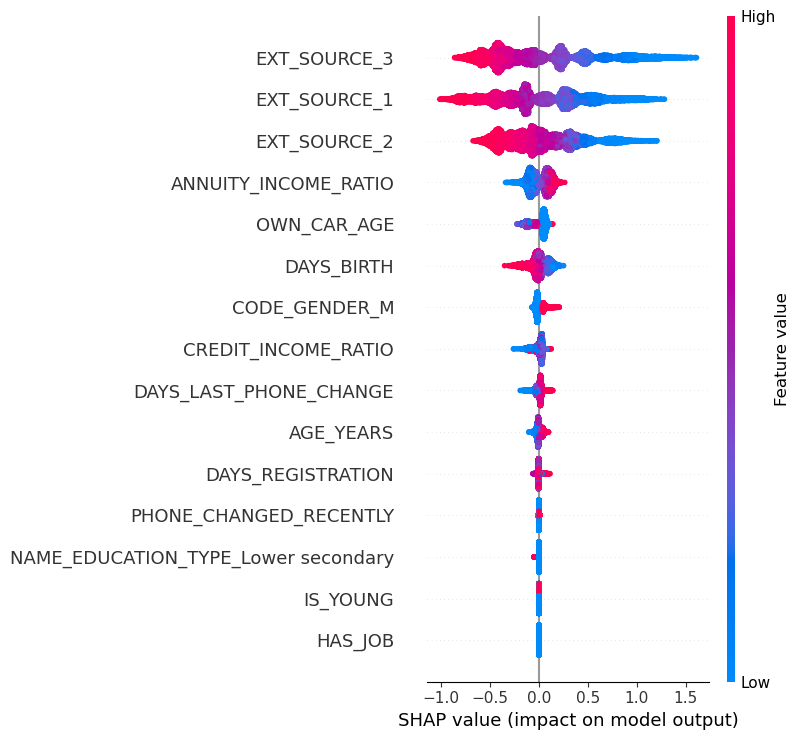

In [44]:
# Summary plot avec les valeurs (effets directionnels)
shap.summary_plot(shap_values, X_val_enriched)

Analyse des résultats SHAP globaux :
1. Graphique à barres (mean SHAP)

Il montre l’importance moyenne absolue de chaque variable sur les prédictions du modèle.

Les 3 variables EXT_SOURCE (1, 2, 3) dominent nettement l’explication.

Les variables personnalisées comme ANNUITY_INCOME_RATIO, OWN_CAR_AGE, CREDIT_INCOME_RATIO commencent à apparaître, ce qui valide leur pertinence.

HAS_JOB et IS_YOUNG sont présentes, mais avec très peu d’impact global.

2. Graphique de type beeswarm (valeurs SHAP individuelles)

Il permet de voir comment chaque valeur d’une variable influence la prédiction.

Par exemple :

Pour EXT_SOURCE_3, des valeurs élevées (rose) poussent le modèle vers la classe 0 (non défaillant).

Pour ANNUITY_INCOME_RATIO, les valeurs faibles (bleu) sont plutôt associées à des prédictions vers la classe 1 (défaillant).


--- SHAP pour l'individu 0 ---


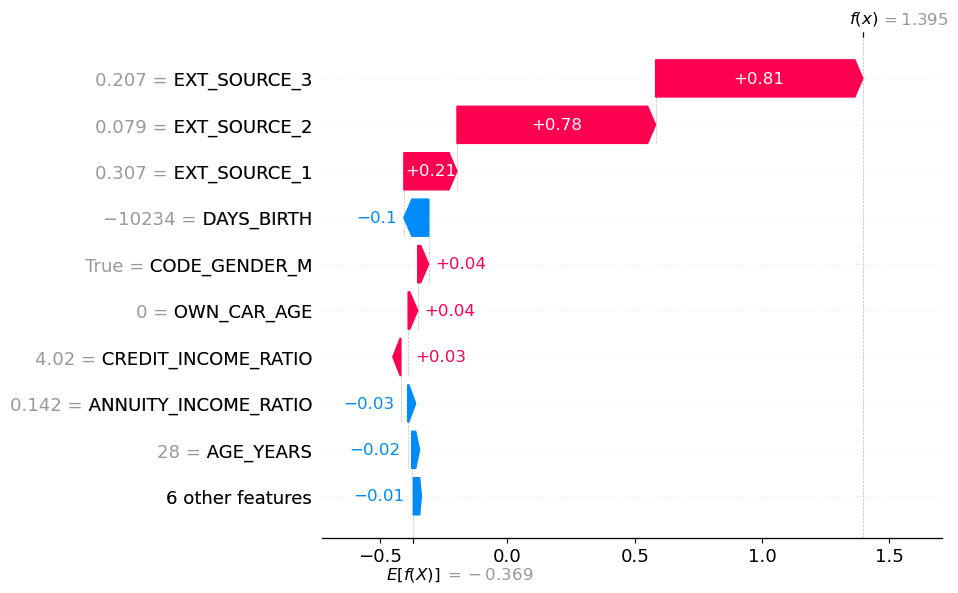


--- SHAP pour l'individu 1 ---


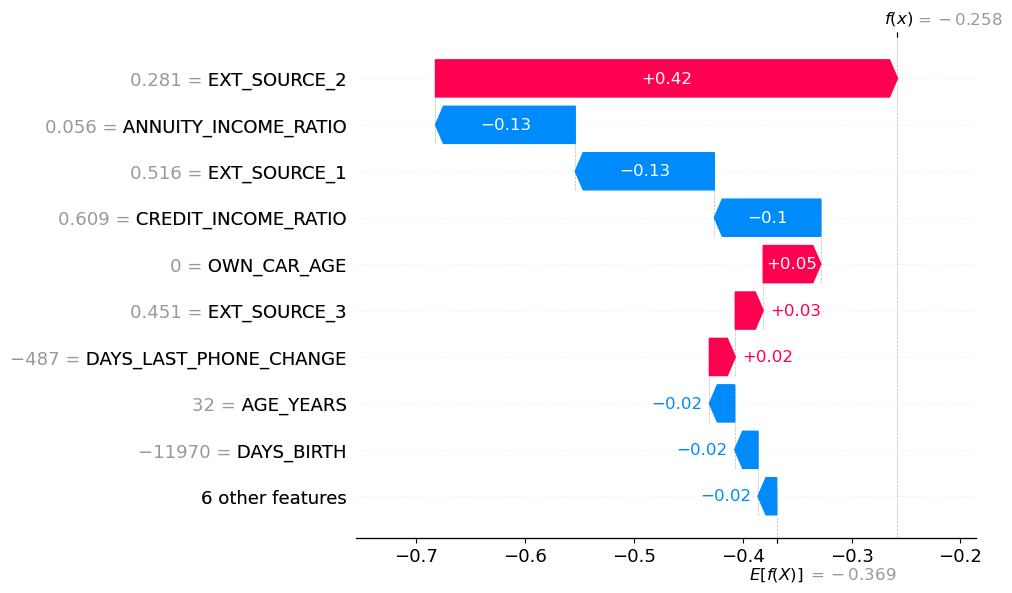


--- SHAP pour l'individu 5 ---


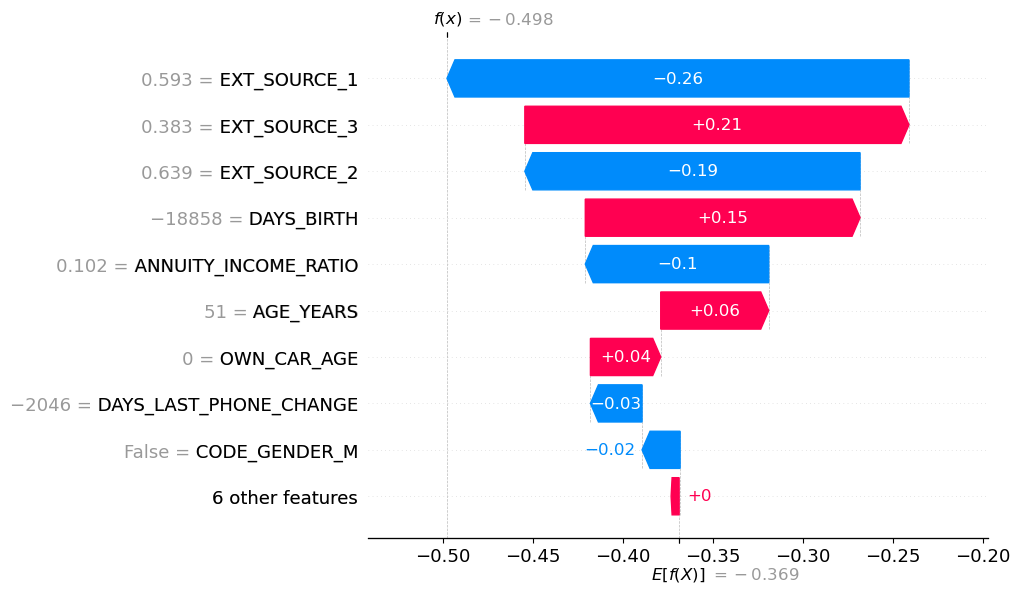


--- SHAP pour l'individu 42 ---


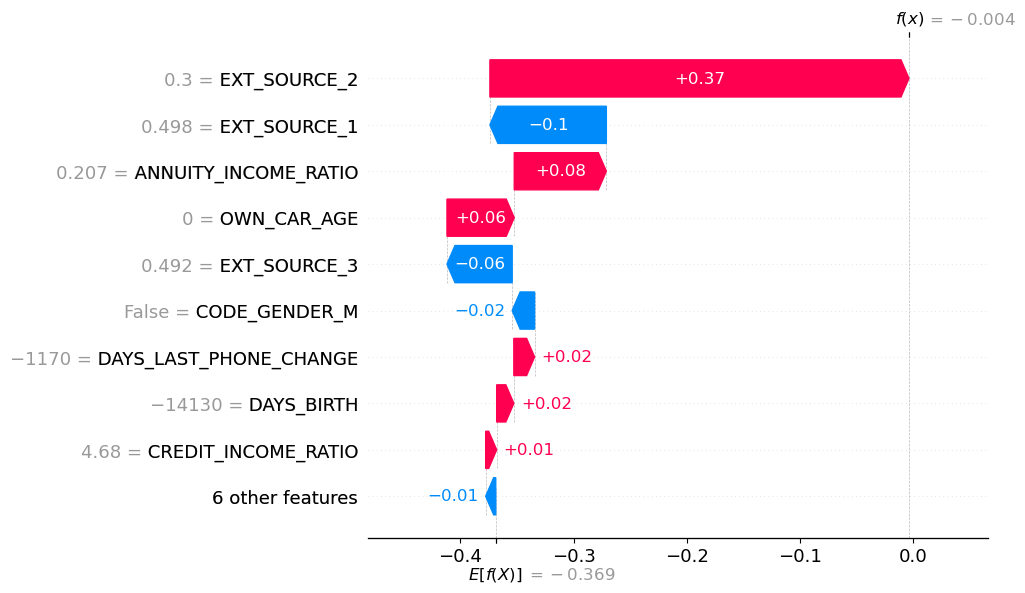


--- SHAP pour l'individu 100 ---


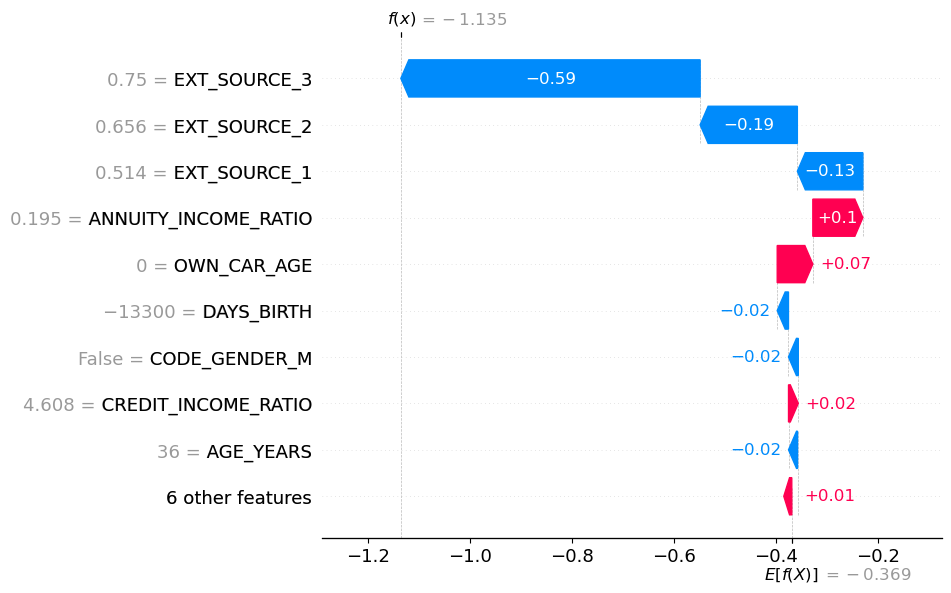

In [45]:
# Explicabilité locale (SHAP waterfall plots)

# Comprendre pourquoi un individu est prédit comme à risque

# Expliquer une décision client par client

# Choix d’un ou plusieurs individus à expliquer
indices_to_explain = [0, 1, 5, 42, 100]  # personnalise selon ton besoin

# Visualisation SHAP locale (waterfall)
for idx in indices_to_explain:
    print(f"\n--- SHAP pour l'individu {idx} ---")
    shap.plots.waterfall(shap_values[idx], max_display=10)
    plt.show()

In [46]:
# Exemple : log-odds extraits des waterfall plots
log_odds = [1.395, -0.258, -0.498, -0.004, -1.135]

# Fonction sigmoïde
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Conversion
probabilities = [sigmoid(fx) for fx in log_odds]

# Affichage
for i, (fx, prob) in enumerate(zip(log_odds, probabilities)):
    print(f"Individu {i}: f(x) = {fx:.3f} → Probabilité = {prob:.3%}")

Individu 0: f(x) = 1.395 → Probabilité = 80.139%
Individu 1: f(x) = -0.258 → Probabilité = 43.586%
Individu 2: f(x) = -0.498 → Probabilité = 37.801%
Individu 3: f(x) = -0.004 → Probabilité = 49.900%
Individu 4: f(x) = -1.135 → Probabilité = 24.324%


Individu 0

Prédiction du modèle : élevée (f(x) = 1.395) → risque important.

Facteurs majeurs qui augmentent le risque :

EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 : très faibles → très négatif pour le profil.

Facteurs qui diminuent un peu le risque :

DAYS_BIRTH (plus âgé), ANNUITY_INCOME_RATIO faible.

Conclusion : le modèle juge cet individu comme très risqué, car il est très mal noté sur les sources externes de score (EXT_SOURCE_*), qui sont fortement corrélées au risque.

Individu 1

Prédiction du modèle : faible (f(x) = -0.258) → client plutôt sûr.

Facteurs qui diminuent fortement le risque :

ANNUITY_INCOME_RATIO, EXT_SOURCE_1, CREDIT_INCOME_RATIO : bons scores.

Facteur qui augmente légèrement le risque :

EXT_SOURCE_2, OWN_CAR_AGE.

Conclusion : Ce client est perçu comme peu risqué, car il a une bonne stabilité financière relative à ses revenus.

Individu 5

Prédiction du modèle : faible (f(x) = -0.498) → bon client.

Facteurs protecteurs :

EXT_SOURCE_1, EXT_SOURCE_2, DAYS_BIRTH → favorables.

Quelques facteurs de risque modérés :

EXT_SOURCE_3, ANNUITY_INCOME_RATIO.

Conclusion : Client bien noté sur les critères de scoring externes et l’âge, donc plutôt fiable.

Individu 42

Prédiction du modèle : très proche de 0 (f(x) = -0.004) → borderline.

Facteurs positifs :

EXT_SOURCE_1 et EXT_SOURCE_3.

Facteurs négatifs :

EXT_SOURCE_2 très mauvais, ANNUITY_INCOME_RATIO un peu élevé.

Conclusion : Profil équilibré, légèrement risqué à cause d’un mauvais score EXT_SOURCE_2.

Individu 100

Prédiction du modèle : très faible (f(x) = -1.135) → excellent client.

Facteurs très positifs :

Très bons scores sur EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1.

Facteurs neutres ou peu impactants :

Les autres variables n’ont qu’un faible poids.

Conclusion : Profil idéal du point de vue du modèle. Les scores externes de risque sont excellents.

Individu---------Score modèle (f(x))-------Risque perçu----------Raisons principales

0------------	+1.39-----------------------Très risqué----------Mauvais EXT_SOURCE_*, jeune

1-------------- -0.26	--------------------Faible risque---------Bon ratio crédit/revenu

5------------	-0.50	--------------------Faible risque---------Bon âge + bonnes sources externes

42-----------	≈ 0	--------------------------Limite--------------Score EXT_SOURCE_2 faible

100---------	-1.13	----------------------Très sûr------------Tous les EXT_SOURCE élevés